# BEE 4750 Homework 3: Dissolved Oxygen and Monte Carlo

**Name**: Gianna Weidman

**ID**: grw64

> **Due Date**
>
> Thursday, 10/03/23, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to implement a model for dissolved oxygen in a
    river with multiple waste releases and use this to develop a
    strategy to ensure regulatory compliance.
-   Problem 2 asks you to use Monte Carlo simulation to assess how well
    your strategy from Problem 1 performs under uncertainty.
-   Problem 3 (5750 only) asks you to identify where a third discharge
    should be placed to maintain regulatory compliance.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [57]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Local/Coding Projects/BEE4570/hw3-super-awesome-team-name-1`


In [58]:
using Random
using Plots
using LaTeXStrings
using Distributions
using CSV
using DataFrames

## Problems (Total: 50/60 Points)

### Problem 1 (30 points)

A river which flows at 6 km/d is receiving waste discharges from two
sources which are 15 km apart. The oxygen reaeration rate is 0.55
day<sup>-1</sup>, and the decay rates of CBOD and NBOD are are 0.35 and
0.25 day<sup>-1</sup>, respectively. The river’s saturated dissolved
oxygen concentration is 10m g/L.

If the characteristics of the river inflow and waste discharges are
given in <a href="#tbl-river" class="quarto-xref">Table 1</a>, write a
Julia model to compute the dissolved oxygen concentration from the first
wastewater discharge to an arbitrary distance `d` km downstream. Use
your model to compute the maximum dissolved oxygen concentration up to
50km downstream and how far downriver this maximum occurs.

| Parameter | River Inflow | Waste Stream 1 | Waste Stream 2 |
|:--:|---:|---:|---:|
| Inflow | 100,000 m<sup>3</sup>/d | 10,000 m<sup>3</sup>/d | 15,000 m<sup>3</sup>/d |
| DO Concentration | 7.5 mg/L | 5 mg/L | 5 mg/L |
| CBOD | 5 mg/L | 50 mg/L | 45 mg/L |
| NBOD | 5 mg/L | 35 mg/L | 35 mg/L |

Table 1: River inflow and waste stream characteristics for Problem 1.

**In this problem**:

-   Plot the dissolved oxygen concentration from the first waste stream
    to 50m downriver. What is the minimum value in mg/L?
-   What is the minimum level of treatment (% removal of organic waste)
    for waste stream 1 that will ensure that the dissolved oxygen
    concentration never drops below 4 mg/L, assuming that waste stream 2
    remains untreated? How about if only waste stream 2 is treated?
-   Suppose you are responsible for designing a waste treatment plan for
    discharges into the river, with a regulatory mandate to keep the
    dissolved oxygen concentration above 4 mg/L. Discuss whether you’d
    opt to treat waste stream 2 alone or both waste streams equally.
    What other information might you need to make a conclusion, if any?

#### Problem 1 solution

The first step in solving this problem is finding the intial concentrations of DO, CBOD, and NBOD, where the river inflow meets waste stream 1. This is done by a simple mass balance. Then, using those initial concentrations, the Streeter-Phelps equation is used to find the DO concentration over distance x:

$C(d) = C_s(1-\alpha_1)+C_0\alpha_1-B_0\alpha_2-N_0\alpha_3+\frac{(P-R-S_B)}{k_a}(1-\alpha_1)\\
a_1=\exp(-\frac{k_ad}{U})\\
a_2=(\frac{k_c}{k_a-k_c})[\exp(-\frac{k_cd}{U})-\exp(-\frac{k_ad}{U})]\\
a_3=(\frac{k_n}{k_a-k_n})[\exp(-\frac{k_nd}{U})-\exp(-\frac{k_ad}{U})]\\$

with $P,R,S_B$ terms not considered. 

This model is applied for distances $d$ from 0 km to 14 km. At 15 km downstream, the river encounters another mixing point with discharge 2. The concentrations of DO, CBOD, and NBOD at $d=14$ is used as the new "initial" concentrations in the river, and a mass balance is done with the discharge 2 concentratrations. The Streeter-Phelps equations are applied again using these new initial values, and this time from a distance of 0 km to 34 km. While we want the distance of at least 50 km downstream, because we started from different initial conditions, we can restart at $d=0$ again when applying the model.

Finally, the results from these two Streeter-Phelps implementations are combined into a single array showing the DO over time from $d=0$ to $d=50$.

The minimum DO concentration is 3.7581 mg/L DO, found at about 23 km downstream.

Regarding treatment, treating only waste discharge 1 by removing 17% of organic waste would ensure that the DO downstream did not drop below 4 mg/L. Similarly, if only waste 2 were treated, the percent removal is 13%. 

I would treat stream 1 alone because it would be a more efficient use of resources to attend to only one stream. It also gives you a little more control over the dynamics of that one waste stream.

minimum(C) = 3.758144658713217


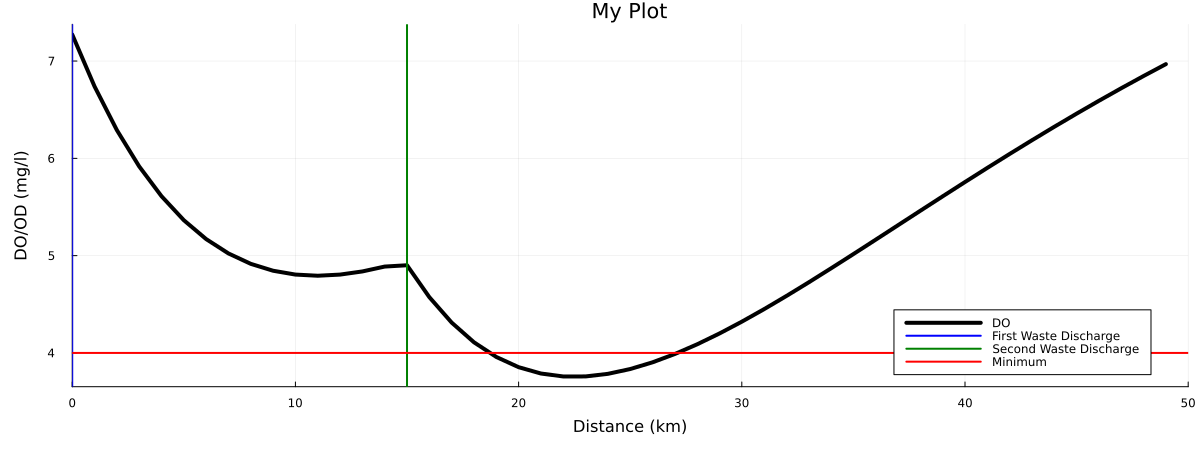

In [59]:
# Problem 1 Model and plot Code
using Plots
using Plots.PlotMeasures

# Givens
Qr0 = 100000     # m3/day
Qw1 = 10000
Qw2 = 15000

Cr0 =7.5        # mg/L
Cw1 = 5
Cw2 = 5

Br0 = 5           # mg/L
Bw1 = 50
Bw2 = 45

Nr0 = 5          # mg/L
Nw1 = 35
Nw2 = 35

ka = 0.55       # /day
kc = 0.35
kn = 0.25

U = 6
Cs = 10

# Define model

function do_model(x, C0, B0, N0, ka, kn, kc, Cs, U)
    B = B0 * exp(-kc * x / U)
    N = N0 * exp(-kn * x / U)
    α1 = exp(-ka * x / U)
    α2 = (kc/(ka-kc)) * (exp.(-kc * x / U) - exp(-ka * x / U))
    α3 = (kn/(ka-kn)) * (exp(-kn * x / U) - exp(-ka * x / U))
    C = Cs * (1 - α1) + (C0 * α1) - (B0 * α2) - (N0 * α3)
    return (C, B, N)
end

# Doing the problem

"""# Waste stream 1 treatment
e = 0.83
Bw1 = Bw1 * e
Nw1 = Nw1 * e

Waste stream 2 treatment
e = 0.87
Bw2 = Bw2 * e
Nw2 = Nw2 * e"""


# Find initial values
# called r1 because its after the river mixes with first waste

Cr1 = (Qr0 * Cr0 + Qw1 * Cw1) / (Qr0 + Qw1)
Br1 = (Qr0 * Br0 + Qw1 * Bw1) / (Qr0 + Qw1)
Nr1 = (Qr0 * Nr0 + Qw1 * Nw1) / (Qr0 + Qw1)
Qr2 = Qr0 + Qw1     # yes, skipping Qr1

# set range of distances
x = 0:14

# First mixing site
model_out = (y -> do_model(y, Cr1, Br1, Nr1, ka, kc, kn, Cs, U)).(x)

C = [d[1] for d in model_out]
B = [d[2] for d in model_out]
N = [d[3] for d in model_out]

# Second mixing site "initial" values
Cr2 = C[length(C)]
Br2 = B[length(B)]
Nr2 = N[length(N)]

# Mixing occurs
Cr2 = (Qr2 * Cr2 + Qw2 * Cw2) / (Qr2 + Qw2)
Br2 = (Qr2 * Br2 + Qw2 * Bw2) / (Qr2 + Qw2)
Nr2 = (Qr2 * Nr2 + Qw2 * Nw2) / (Qr2 + Qw2)

# Rest of the model
x = 0:34

model_out = (y -> do_model(y, Cr2, Br2, Nr2, ka, kc, kn, Cs, U)).(x)

C = append!(C, [d[1] for d in model_out])
B = append!(B, [d[2] for d in model_out])
N = append!(N, [d[3] for d in model_out])

x = 0:49

@show minimum(C)

# Plotting
p1 = plot(; ylabel="DO/OD (mg/l)", xlabel="Distance (km)", leftmargin=8mm, bottommargin=8mm)
plot!(p1, x, C, color=:black, linewidth=4, label="DO", title="My Plot")
vline!([0], color=:blue, linewidth=2, label="First Waste Discharge")
vline!([15], color=:green, linewidth=2, label="Second Waste Discharge")
hline!([4], color=:red, linewidth=2, label="Minimum")
plot!(size=(1200, 450))
xaxis!((0, length(x)))

### Problem 2 (20 points)

The simplest climate model involves capturing changes to the Earth’s
energy budget (it is commonly called the *energy balance model*, or
EBM). These changes are also called *radiative forcings* (RF), and can
result from several causes, including greenhouse gas emissions, volcanic
eruptions, and changes to the solar cycle. The EBM treats the Earth as a
0-dimensional sphere covered with water, which absorbs heat in response
to radiative forcings. Chanwith global temperature changes resulting
from imbalances in the average (over the entire surface area) heat flux.

The EBM equations are:

$$
\begin{align*}
\overbrace{\frac{dH}{dt}}^{\text{change in heat}} &= \overbrace{F}^{\substack{\text{radiative} \\ \text{forcing}}} - \overbrace{\lambda T}^{\substack{\text{change in} \\ \text{temperature}}} \\
\underbrace{C}_{\substack{\text{ocean heat} \\ \text{capacity}}} \frac{dT}{dt} &= F - \lambda T \\
c\underbrace{d}_{\substack{\text{ocean} \\ \text{mixing depth}}} \frac{dT}{dt} &= F - \lambda T,
\end{align*}
$$

where $c = 4.184\times 10^6 \mathrm{J/K/m}^2$ is the specific heat of
water per area, $d$ is the depth of the ocean mixed layer (we’ll assume
$d = 86 \mathrm{m}$), and $\lambda$ is the **climate feedback factor**
and controls how much the Earth warms in response to increased radiative
forcing (assume
$\lambda = 2.1^\circ (\mathrm{W}/\mathrm{m}^2)/ \mathrm{C}$). The total
radiative forcing $F = F_\text{non-aerosol} + \alpha F_\text{aerosol}$,
where $\alpha$ is an uncertain scaling factor reflecting aerosol-cloud
feedbacks (we’ll assume $\alpha = 0.8$).

The code below loads historical and projected radiative forcings (under
the SSP5-8.5 future emissions scenario, which is the most extreme of the
scenarios used to project climate change impacts) from
`data/ERF_ssp585_1750-2500.csv` into a `DataFrame` object and calculates
the non-aerosol and aerosol components of those forcings.

> **Tip**
>
> Look closely at and experiment with the code below: `DataFrames` are a
> common Julia datatype for tabular data, and you may work more with
> them later in the semester or beyond! They are broadly similar to
> `DataFrames` from `pandas` in Python.

In [60]:
# Dataset from https://zenodo.org/record/3973015
# The CSV is read into a DataFrame object, and we specify that it is comma delimited
forcings_all = CSV.read("data/ERF_ssp585_1750-2500.csv", DataFrame, delim=",")

# Separate out the individual components
# Get total aerosol forcings
forcing_aerosol_rad = forcings_all[!,"aerosol-radiation_interactions"]
forcing_aerosol_cloud = forcings_all[!,"aerosol-cloud_interactions"]
forcing_aerosol = forcing_aerosol_rad + forcing_aerosol_cloud
# Calculate non-aerosol forcings from the total.
forcing_total = forcings_all[!,"total"]
forcing_non_aerosol = forcing_total - forcing_aerosol

@show t

t = [1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915,

751-element Vector{Int64}:
 1750
 1751
 1752
 1753
 1754
 1755
 1756
 1757
 1758
 1759
    ⋮
 2492
 2493
 2494
 2495
 2496
 2497
 2498
 2499
 2500

We can plot the aerosol and non-aerosol forcings below.

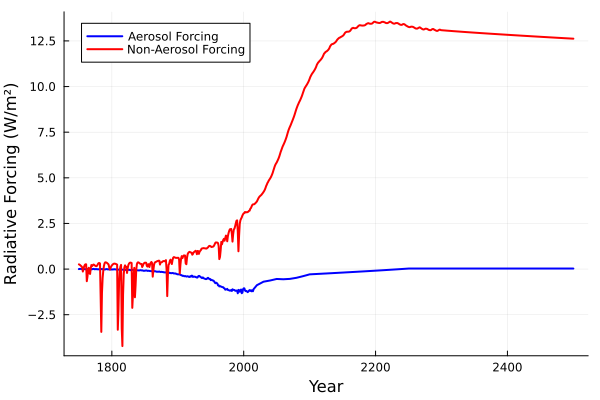

In [61]:
t = Int64.(forcings_all[!,"year"]) # Ensure that years are interpreted as integers
p_forcing = plot(; xlabel="Year", ylabel="Radiative Forcing (W/m²)")
plot!(p_forcing, t, forcing_aerosol, label="Aerosol Forcing", color=:blue, linewidth=2)
plot!(p_forcing, t, forcing_non_aerosol, label="Non-Aerosol Forcing", color=:red, linewidth=2)
#plot!(p_forcing, t, forcing_total, label="Forcing Total", color=:green, linewidth=2)

**In this problem**:

-   Discretize the EBM to produce a simulation model of global mean
    temperatures $T$ over time as a result of total radiative forcings
    $F$.

-   Simulate global mean temperature anomalies (in $^\circ C$ relative
    to 1750) from your model using the historical and SSP5-8.5 radiative
    forcing data. Use an annual time step for the simulation (in
    seconds: $\Delta t = 31,558,152 \mathrm{s}$). You can assume
    $T(0) = 0^\circ C$. Plot the resulting temperature simulation.

-   The climate feedback factor $\lambda$ is one of the key
    uncertainties in projecting future temperatures, even assuming a
    particular scenario of future radiative forcing. Suppose we use the
    following distribution for $\lambda$,
    $$\lambda \sim \text{LogNormal}(\log(2.1), \log(2)/4).$$

    Use Monte Carlo simulation to estimate the expected temperature in
    2100 assuming SSP5-RCP 8.5 radiative forcings (with 95% confidence
    intervals). How does this estimate compare to the value you got from
    your simulation using the expected value of
    $\lambda=2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2)$? How did
    you decide your sample set was sufficient?

### Problem 2 my solution

To discretize, I took $cd\frac{dT}{dt} = F - \lambda T$ and changed it such that $cd\Delta T = (F - \lambda T)\Delta t$ was the new equation. Then, using Julia, I developed a function that would calculate $\Delta T$ given a $T$ and a number for total radiative forcing. I made sure to use the value of $31558152$ seconds for each timestep.

The 95% confidence interval is found using the expression

$\mu_n \pm 1.96\frac{\sigma_n}{\sqrt{n}}$


And can be found for each iteration $n$ of the Monte Carlo simulation. In finding the expected temperature in 2100, I took the average of the so far calculated estimates. I started with $n=1000$ iterations, sampling 1000 potential $\lambda$ from the given lognormal distribution. In applying the confidence interval equation, at each iteration, I would calculate the square root of the variance so far for the term $\sigma_n$ and the square root of which iteration it was for the $\sqrt n$ term. For $\mu_n$, I used the mean of the all of the 2100 temperatures guessed so far.

At the end of this analysis at $n=1000$, $4.648 \pm 0.084$ was the value for a 95% confidence interval. This is a pretty satisfying result to me, because the uncertainty is rather small, less than a fifth of a degree. Looking at the plot generated of the guess though, I didn't look like the model had yet found a stable point. So I increased it to $n=2000$, which yielded results of $4.6633 +/- 0.0465$ for the 95% confidence interval. This plot looked a lot better, so I think this is a better number of samples to use.

Increasing this by a factor of 10 just to see what happens to $n=10000$, the 95% confidence interval is $4.651 \pm 0.0204$. The range of uncertainty is a little smaller ($0.0204$ compared to $0.0465$), but ultimately I think this small difference in negligble compared to how much longer the model took to run. Also, both guesses are in the same 10th of a degree, guessing $4.6$ C as the temperature in 2100. For this reason, I would ultimately choose to go with the model using 2000 samples and iterations.



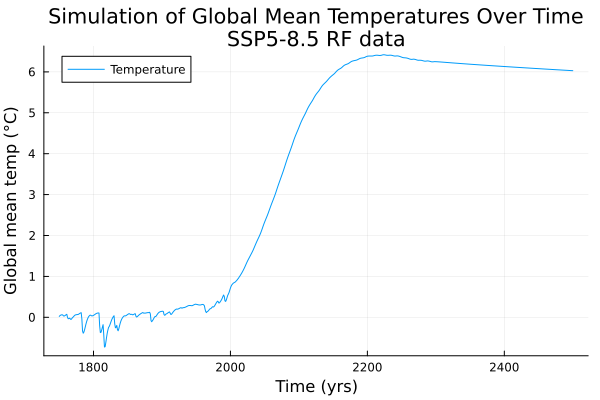

In [62]:
# define constants
d = 86          # m
l = 2.1    # ºC W/m2
c = (4.184 * 10^6)

function change_T(T, i, lambda)
    return ((forcing_total[i] - T * lambda) * 31558152) / (c * d)
end


temps = []
changes = []
T = 0
for num in 1:length(t)
    change = change_T(T, num, l)
    T = T + change
    append!(changes, change)
    append!(temps, T)
end

plot(t, temps, title="Simulation of Global Mean Temperatures Over Time\nSSP5-8.5 RF data", label="Temperature", xlabel="Time (yrs)", ylabel="Global mean temp (°C)")

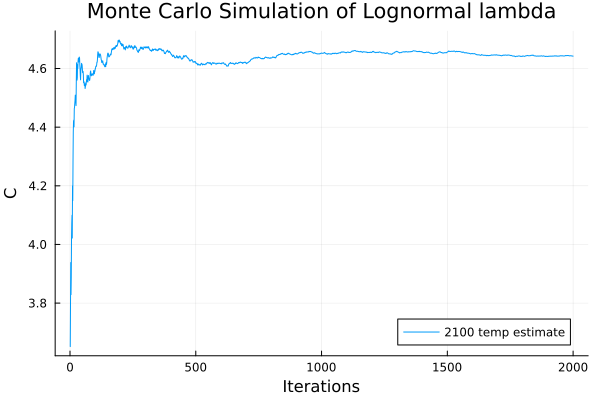

In [63]:
# 
using Random, Distributions

lambda_dist = LogNormal(log(2.1),log(2)/4)
lambda_sampling = rand(lambda_dist, 2000)

function run_til_2100(lambda)
    T = 0
    for num in 1:350
        change = change_T(T, num, lambda)
        T = T + change
    end
    return T
end

iter_results = []
running_guess = []
running_pc = []
pm = []
for i in lambda_sampling
    new = run_til_2100(i)  
    append!(iter_results, new)
    append!(running_guess, mean(iter_results))
    append!(pm, 1.96 * sqrt(var(running_guess)) / sqrt(i))
end

plot(running_guess, title="Monte Carlo Simulation of Lognormal lambda", label="2100 temp estimate", ylabel="C", xlabel="Iterations")

In [64]:
print("95% Confidence Interval: ", running_guess[length(running_guess)], " +/- ", pm[length(pm)])

95% Confidence Interval: 4.6422386175663375 +/- 0.07732996050688053

### Problem 3 (10 points)

**This problem is only required for students in BEE 5750**.

A factory is planning a third wastewater discharge into the river
downstream of the second plant. This discharge would consist of 5
m<sup>3</sup>/day of wastewater with a dissolved oxygen content of 4.5
mg/L and CBOD and NBOD levels of 50 and 45 mg/L, respectively.

**In this problem**:

-   Assume that the treatment plan you identified in Problem 1 is still
    in place for the existing discharges. If the third discharge will
    not be treated, under the original inflow conditions (7.5 mg/L DO),
    how far downstream from the second discharge does this third
    discharge need to be placed to keep the river concentration from
    dropping below 4 mg/L?

## References

List any external references consulted, including classmates.